<a href="https://colab.research.google.com/github/babuus/Machine-Learning/blob/master/Digit_Recognizer_Acc_0_99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle #For downloading datasets
!pip install livelossplot #For displaying live plots of training

In [2]:
#Import functions
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from google.colab import files
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [3]:
#uploading Kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"babuus","key":"8d8c3864d8bc1568f7b7841b4a66314d"}'}

In [5]:
#Download dataset from kaggle
%%bash
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
mkdir ZIP
cd ZIP
kaggle competitions download -c digit-recognizer

mkdir: cannot create directory ‘ZIP’: File exists
100%|##########| 6.09M/6.09M [00:00<00:00, 56.1MB/s]
100%|##########| 9.16M/9.16M [00:00<00:00, 44.9MB/s]
100%|##########| 235k/235k [00:00<00:00, 76.8MB/s]


In [6]:
#Extracting folders
!mkdir /content/Dataset
!unzip /content/ZIP/test.csv.zip -d /content/Dataset
!unzip /content/ZIP/train.csv.zip -d /content/Dataset

Archive:  /content/ZIP/test.csv.zip
  inflating: /content/Dataset/test.csv  
Archive:  /content/ZIP/train.csv.zip
  inflating: /content/Dataset/train.csv  


In [7]:
#Read data
train = pd.read_csv('/content/Dataset/train.csv')
test = pd.read_csv('/content/Dataset/test.csv')
y = train['label']
#Reshaping to (,28,28,1)
X = train.drop(labels = ["label"],axis = 1).values.reshape(-1,28,28,1)
X = X/255
test = test.values.reshape(-1,28,28,1)
print(X.shape, y.shape, test.shape)
train.head(1)

(42000, 28, 28, 1) (42000,) (28000, 28, 28, 1)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_train[0].shape

((31500, 28, 28, 1), (31500,), (10500, 28, 28, 1), (10500,), (28, 28, 1))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


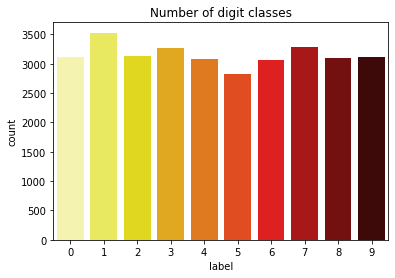

In [9]:
#Displaying count
sns.countplot(y_train, palette="hot_r");
plt.title("Number of digit classes");

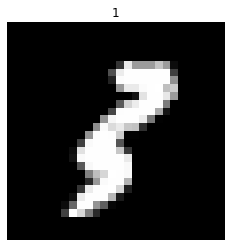

In [10]:
#Displaying images
img = np.array(X_train[3]).reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[0,0])
plt.axis("off")
plt.show()

In [17]:
#Model
cnn = keras.Sequential()

cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
cnn.add(keras.layers.BatchNormalization())
# cnn.add(keras.layers.MaxPooling2D((4,4)))
# cnn.add(keras.layers.Dropout(0.25))

cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(keras.layers.BatchNormalization())
cnn.add(keras.layers.MaxPooling2D((2, 2)))
# cnn.add(keras.layers.Dropout(0.25))

cnn.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(keras.layers.BatchNormalization())

cnn.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(keras.layers.BatchNormalization())
cnn.add(keras.layers.MaxPooling2D((2, 2)))
# cnn.add(keras.layers.Dropout(0.25))

cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(64, activation='relu'))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Dense(10, activation='softmax'))

cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 64)       

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
#ImageDataGenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,
        rotation_range=10,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,
        horizontal_flip=False, 
        vertical_flip=False)
datagen.fit(X_train)

In [ ]:
#With datagen
history = cnn.fit(datagen.flow(X_train, y_train, batch_size=20),
        #  validation_data=datagen.flow(X, y,batch_size=8, subset='validation'),
        validation_data = (X_test, y_test),
         steps_per_epoch=np.ceil((len(X_train)*0.8/20)-1),
        #  validation_steps=np.ceil((len(X)*0.2/20)-1),
         callbacks=[learning_rate_reduction],
         epochs=50)

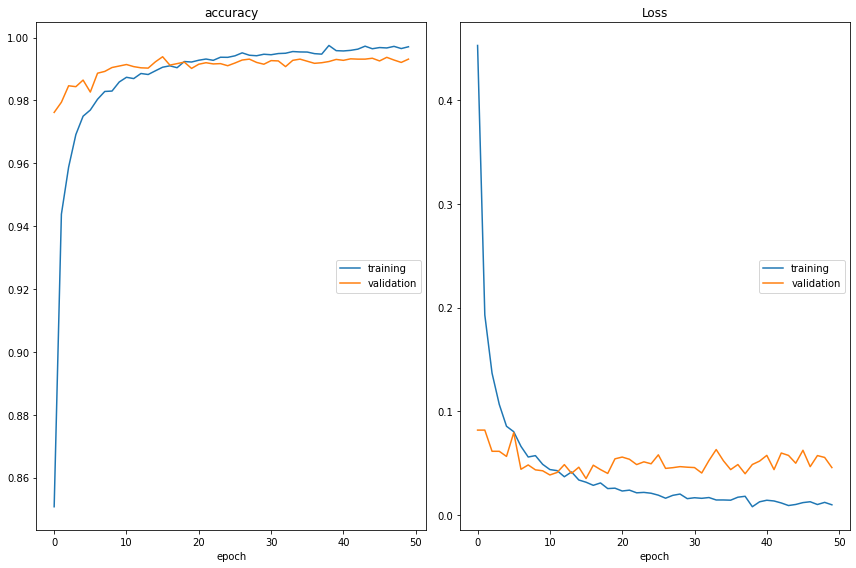

accuracy
	training         	 (min:    0.851, max:    0.997, cur:    0.997)
	validation       	 (min:    0.976, max:    0.994, cur:    0.993)
Loss
	training         	 (min:    0.008, max:    0.452, cur:    0.010)
	validation       	 (min:    0.035, max:    0.082, cur:    0.046)


In [18]:
#Without datagen
history1 = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[PlotLossesKeras()], epochs=50)

In [13]:
pred = cnn.predict(test)
result = [np.argmax(i) for i in pred]
result_pd = pd.DataFrame([i for i in range(1,28001)], columns=['ImageId'])
result_pd['Label'] = result

In [14]:
result_pd.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [15]:
result_pd.to_csv('submission.csv', index=False)

In [16]:
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "Cnn"

100% 208k/208k [00:01<00:00, 117kB/s]
Successfully submitted to Digit Recognizer